# Import Library

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Handling imbalanced datasets
from imblearn.over_sampling import SMOTE

# Model selection and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import (VotingClassifier, StackingClassifier)

# Machine Learning models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier  # Ensure you have xgboost installed

# Evaluation metrics
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score, 
                             recall_score, precision_score, 
                             mean_absolute_error, mean_squared_error, 
                             roc_curve, roc_auc_score)

# Statistical methods
from scipy.stats import mode

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import Dataset

In [2]:
# Load the CSV file
data = pd.read_csv('/kaggle/input/avped-dataset/AntiVped.csv')
data.head()

,Sequence,molecular \nweight,Theoretical Pi,Extinction \ncoefficient,Half life\n(hours),Instability\n index,Aliphatic\n index,GRAVY,Hydrophobic \nresidue :,Net charge:,Boman Index:\n(Kcal/mol),Protective Antigenic\n Score,Allergenicity,property = 1
0,GKPRPYSPRPTSHPRPIRV,2198.56,12.01,1490.0,30.0,41.15,35.79,-1.579,10.0,5.0,3.65,0.5017,no evidence,1
1,ACYCRIPACIAGERRYGTCIYQGRLWAFCC,3448.09,8.68,10345.0,4.4,55.71,65.33,0.3,53.0,3.0,1.07,0.4636,no evidence,1
2,FLFPLITSFLSKVL,1625.03,8.75,NaN,1.1,16.98,160.00,1.75,64.0,1.0,-1.61,0.4303,no evidence,1
3,SNDIYFNFQR,1303.40,5.55,1490.0,1.9,-6.03,39.00,-1.05,30.0,0.0,3.51,0.5745,strong evidence,1
4,GLFSVLGAVAKHVLPHVVPVIAEKL,2594.18,8.61,NaN,30.0,25.92,159.60,1.224,60.0,1.5,-1.13,0.4590,no evidence,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0    Sequence                    3886 non-null   object 
 1   molecular 
weight            3881 non-null   float64
 2   Theoretical Pi               3881 non-null   float64
 3   Extinction 
coefficient      2896 non-null   float64
 4   Half life
(hours)            3881 non-null   float64
 5   Instability
 index           3881 non-null   float64
 6   Aliphatic
 index             3881 non-null   float64
 7   GRAVY                        3879 non-null   object 
 8   Hydrophobic 
residue :       3771 non-null   float64
 9   Net charge:                  3771 non-null   float64
 10  Boman Index:
(Kcal/mol)      3770 non-null   float64
 11  Protective Antigenic
 Score  3867 non-null   float64
 12  Allergenicity                3884 non-null   object 
 13  property = 1      

# Class Distribution

property = 1
1    2082
0    1804
Name: count, dtype: int64


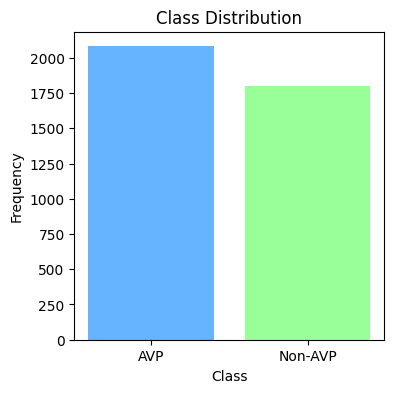

In [4]:
class_counts = data['property = 1'].value_counts()

print(class_counts)

beingsaved = plt.figure(figsize=(4, 4))
colors = ['#66b3ff', '#99ff99']
plt.bar(['AVP', 'Non-AVP'], class_counts.values, color=colors)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
beingsaved.savefig('/kaggle/working/Class_Distribution.png', format='png', dpi=600, bbox_inches="tight")
plt.show()

# Preprocessing Techniques

In [5]:
# Convert non-numeric values to NaN for numeric columns
numeric_columns = ['molecular \nweight', 'Theoretical Pi', 'Extinction \ncoefficient', 
                   'Half life\n(hours)', 'Instability\n index', 'Aliphatic\n index', 
                   'GRAVY', 'Hydrophobic \nresidue :', 'Net charge:', 
                   'Boman Index:\n(Kcal/mol)', 'Protective Antigenic\n Score']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing values for numerical columns with their mean
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Fill missing values for the categorical column 'Allergenicity' with the most frequent value
data['Allergenicity'] = data['Allergenicity'].fillna(data['Allergenicity'].mode()[0])

# Clean up the column names
data.columns = data.columns.str.replace('\n', '').str.strip()

# Encode the 'Allergenicity' column using LabelEncoder
label_encoder = LabelEncoder()
data['Allergenicity'] = label_encoder.fit_transform(data['Allergenicity'])

# Get unique amino acids in the dataset and create encoding
all_amino_acids = set(''.join(data['Sequence'].tolist()))
amino_acid_to_index = {amino_acid: i for i, amino_acid in enumerate(all_amino_acids)}

# Preprocess sequence data using one-hot encoding and pad the sequences
sequences_encoded = []
for sequence in data['Sequence']:
    encoded_sequence = [amino_acid_to_index[amino_acid] for amino_acid in sequence]
    sequences_encoded.append(encoded_sequence)

# Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences_encoded)
sequences_padded = pad_sequences(sequences_encoded, maxlen=max_sequence_length, padding='post')
data['Sequence_Encoded'] = sequences_padded.tolist()

# Ensure the correct target column name here
y = data['property = 1']  # Replace with the actual name of the target column

# Select the features for X (excluding 'Sequence_Encoded' as it's processed separately)
X = data[['Sequence_Encoded', 'molecular weight', 'Extinction coefficient', 'Theoretical Pi', 
          'Half life(hours)', 'Instability index', 'Aliphatic index', 'GRAVY', 
          'Hydrophobic residue :', 'Net charge:', 'Boman Index:(Kcal/mol)', 
          'Protective Antigenic Score', 'Allergenicity']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert sequence data to numpy arrays
X_train_sequences = np.array(X_train['Sequence_Encoded'].tolist())
X_test_sequences = np.array(X_test['Sequence_Encoded'].tolist())

# Flatten the sequence data
X_train_sequences_flat = X_train_sequences.reshape(X_train_sequences.shape[0], -1)
X_test_sequences_flat = X_test_sequences.reshape(X_test_sequences.shape[0], -1)

# Combine the flattened sequence data with other features (drop the 'Sequence_Encoded' column)
X_train_combined = np.hstack((X_train_sequences_flat, X_train.drop(columns=['Sequence_Encoded']).values))
X_test_combined = np.hstack((X_test_sequences_flat, X_test.drop(columns=['Sequence_Encoded']).values))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train)

# Load All Models

In [6]:

# Define individual classifiers with fine-tuned parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=True, eval_metric='logloss', n_estimators=100, max_depth=10)
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=10, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)
ada_model = AdaBoostClassifier(n_estimators=100)

# Define ensemble models
ensemble1 = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('gb', gb_model),
    ('knn', knn_model)
], voting='soft')

ensemble2 = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('gb', gb_model),
    ('ada', ada_model)
], voting='soft')

ensemble3 = StackingClassifier(estimators=[
    ('dt', DecisionTreeClassifier()),
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lr', LogisticRegression(max_iter=1000))
], final_estimator=LogisticRegression(max_iter=1000))

# Initialize classifiers including ensembles
classifiers = {
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Extra Trees': ExtraTreeClassifier(),
    'Random Forest': rf_model,
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Gradient Boosting': gb_model,
    'K-Nearest Neighbors': knn_model,
    'Neural Network': MLPClassifier(),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': ada_model,
    'XGBoost': xgb_model,
    'Ensemble 1': ensemble1, # (RF + XGB + GB + KNN)
    'Ensemble 2': ensemble2, # (RF + XGB + GB + AdaBoost)
    'Ensemble 3': ensemble3 # (DT + RF + XGB + LR)
}

# Evaluation All Models

Model: SVM
Accuracy: 0.7005141388174807
Confusion Matrix:
[[212 133]
 [100 333]]
F1 Score: 0.7408231368186874
Recall: 0.76905311778291
Precision: 0.7145922746781116
Mean Absolute Error: 0.2994858611825193
Root Mean Squared Error: 0.5472530138633495
ROC AUC Score: 0.6917729357030491


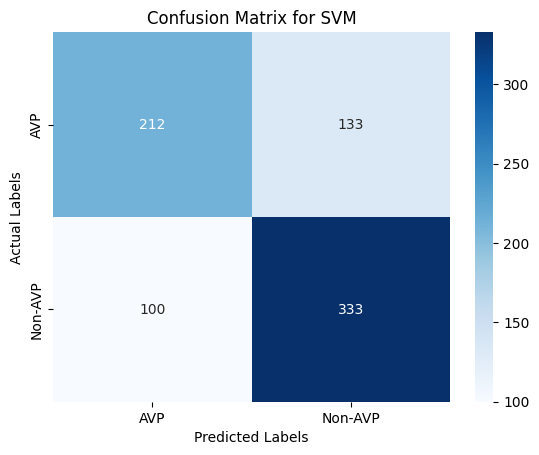

---------------------------------------
Model: Decision Tree
Accuracy: 0.7416452442159382
Confusion Matrix:
[[251  94]
 [107 326]]
F1 Score: 0.7643610785463072
Recall: 0.7528868360277137
Precision: 0.7761904761904762
Mean Absolute Error: 0.2583547557840617
Root Mean Squared Error: 0.5082860963906662
ROC AUC Score: 0.7402115339558858


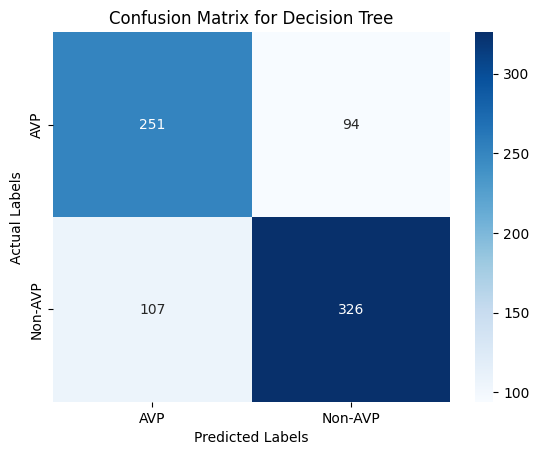

---------------------------------------
Model: Extra Trees
Accuracy: 0.6928020565552699
Confusion Matrix:
[[231 114]
 [125 308]]
F1 Score: 0.7204678362573099
Recall: 0.7113163972286374
Precision: 0.7298578199052133
Mean Absolute Error: 0.30719794344473006
Root Mean Squared Error: 0.5542544031802815
ROC AUC Score: 0.6904408073099709


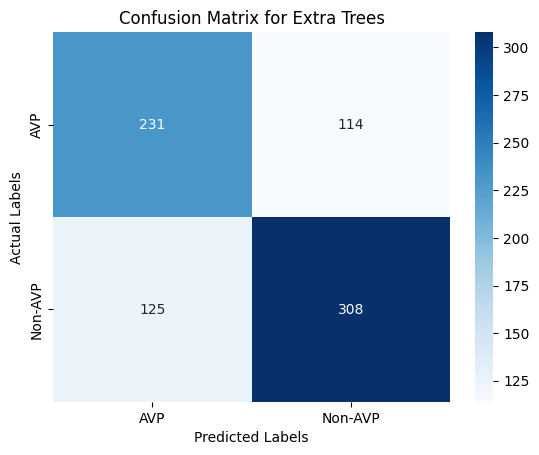

---------------------------------------
Model: Random Forest
Accuracy: 0.8393316195372751
Confusion Matrix:
[[275  70]
 [ 55 378]]
F1 Score: 0.8581157775255392
Recall: 0.8729792147806005
Precision: 0.84375
Mean Absolute Error: 0.16066838046272494
Root Mean Squared Error: 0.4008346048717912
ROC AUC Score: 0.8350403320279813


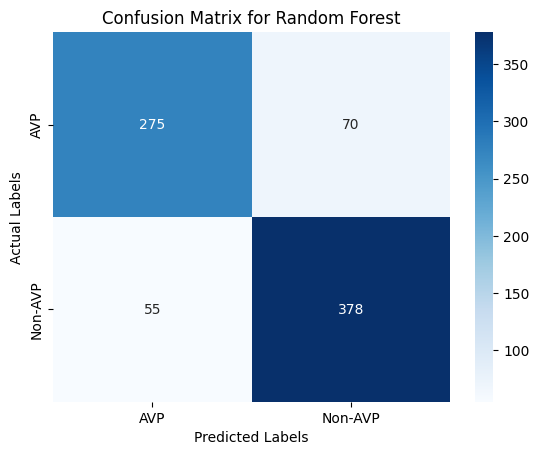

---------------------------------------
Model: Logistic Regression


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6953727506426736
Confusion Matrix:
[[230 115]
 [122 311]]
F1 Score: 0.7240977881257276
Recall: 0.7182448036951501
Precision: 0.7300469483568075
Mean Absolute Error: 0.3046272493573265
Root Mean Squared Error: 0.5519304751119715
ROC AUC Score: 0.6924557351809084


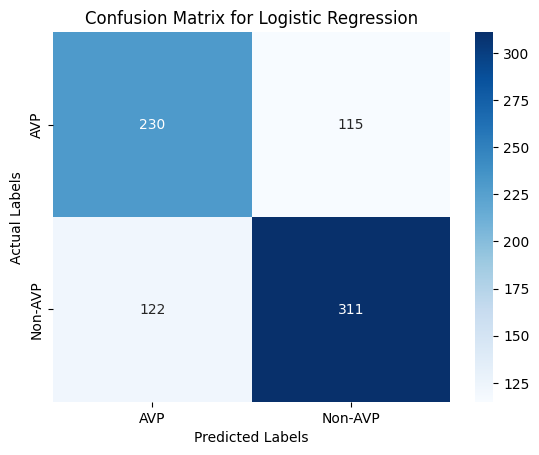

---------------------------------------
Model: Gradient Boosting
Accuracy: 0.8149100257069408
Confusion Matrix:
[[279  66]
 [ 78 355]]
F1 Score: 0.8313817330210773
Recall: 0.8198614318706697
Precision: 0.8432304038004751
Mean Absolute Error: 0.18508997429305912
Root Mean Squared Error: 0.43022084362924484
ROC AUC Score: 0.8142785420222914


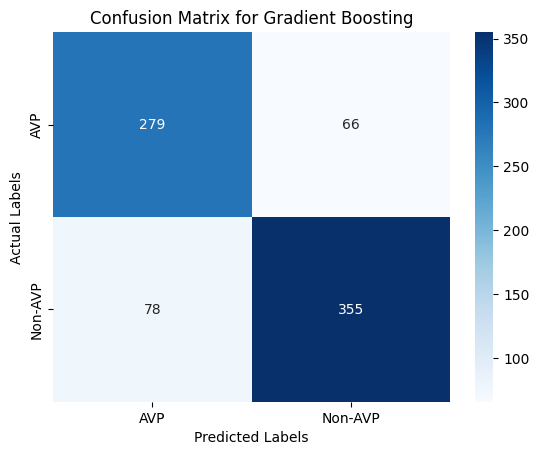

---------------------------------------
Model: K-Nearest Neighbors
Accuracy: 0.7506426735218509
Confusion Matrix:
[[265  80]
 [114 319]]
F1 Score: 0.7668269230769231
Recall: 0.7367205542725174
Precision: 0.7994987468671679
Mean Absolute Error: 0.2493573264781491
Root Mean Squared Error: 0.49935691291715295
ROC AUC Score: 0.7524182481507514


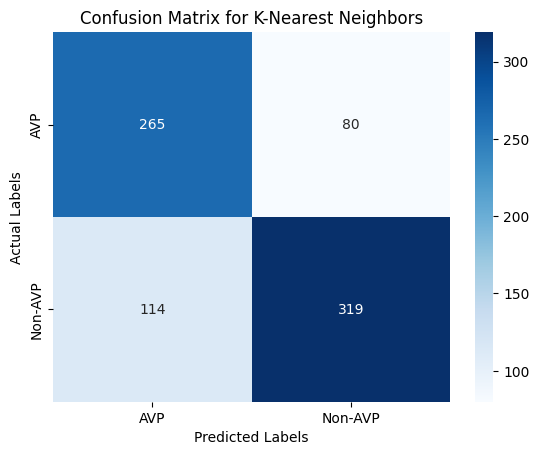

---------------------------------------
Model: Neural Network
Accuracy: 0.6786632390745502
Confusion Matrix:
[[149 196]
 [ 54 379]]
F1 Score: 0.751984126984127
Recall: 0.8752886836027713
Precision: 0.6591304347826087
Mean Absolute Error: 0.3213367609254499
Root Mean Squared Error: 0.5668657344781477
ROC AUC Score: 0.6535863707868929


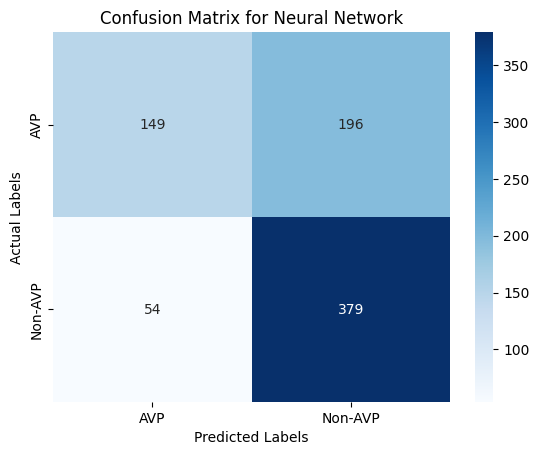

---------------------------------------
Model: Naive Bayes
Accuracy: 0.6696658097686375
Confusion Matrix:
[[174 171]
 [ 86 347]]
F1 Score: 0.729758149316509
Recall: 0.8013856812933026
Precision: 0.6698841698841699
Mean Absolute Error: 0.33033419023136246
Root Mean Squared Error: 0.5747470663094876
ROC AUC Score: 0.6528667536901296


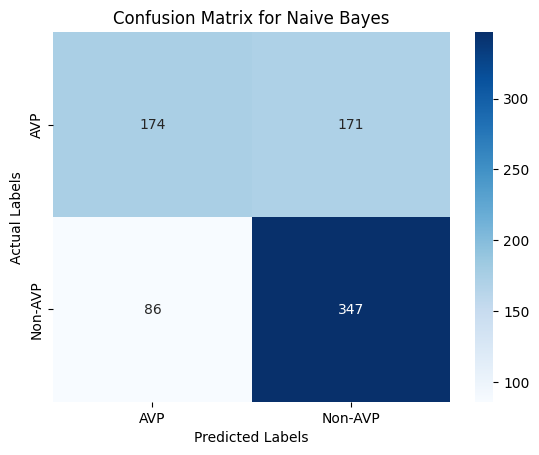

---------------------------------------
Model: AdaBoost
Accuracy: 0.8020565552699229
Confusion Matrix:
[[277  68]
 [ 86 347]]
F1 Score: 0.8183962264150944
Recall: 0.8013856812933026
Precision: 0.8361445783132531
Mean Absolute Error: 0.19794344473007713
Root Mean Squared Error: 0.4449083554284827
ROC AUC Score: 0.8021421160089701


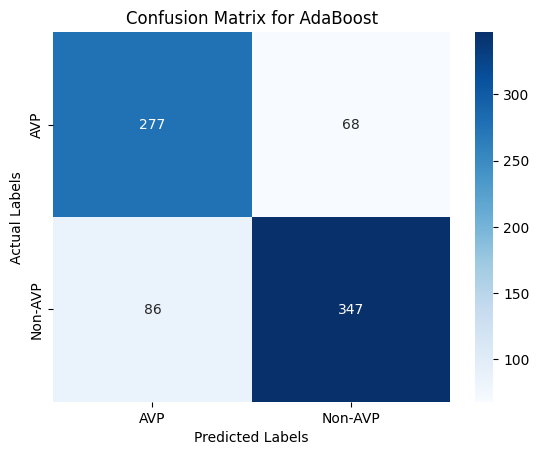

---------------------------------------
Model: XGBoost
Accuracy: 0.8547557840616966
Confusion Matrix:
[[284  61]
 [ 52 381]]
F1 Score: 0.870857142857143
Recall: 0.8799076212471132
Precision: 0.8619909502262444
Mean Absolute Error: 0.14524421593830333
Root Mean Squared Error: 0.38110919162138207
ROC AUC Score: 0.8515480135221074


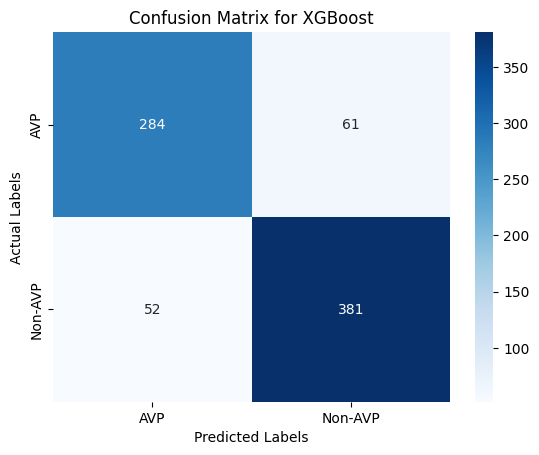

---------------------------------------
Model: Ensemble 1
Accuracy: 0.8624678663239075
Confusion Matrix:
[[286  59]
 [ 48 385]]
F1 Score: 0.8779931584948689
Recall: 0.8891454965357968
Precision: 0.8671171171171171
Mean Absolute Error: 0.13753213367609254
Root Mean Squared Error: 0.3708532508635896
ROC AUC Score: 0.8590655018910868


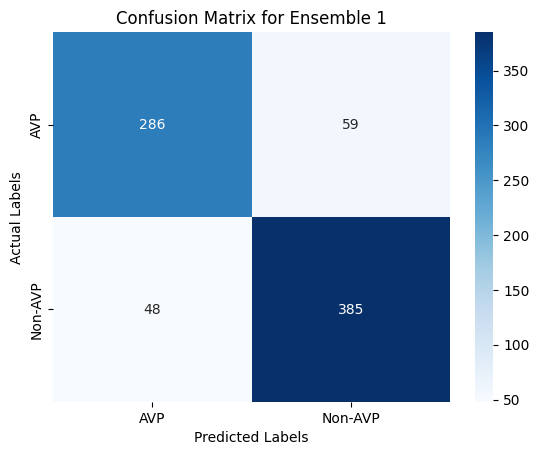

---------------------------------------
Model: Ensemble 2
Accuracy: 0.8521850899742931
Confusion Matrix:
[[284  61]
 [ 54 379]]
F1 Score: 0.8682703321878579
Recall: 0.8752886836027713
Precision: 0.8613636363636363
Mean Absolute Error: 0.14781491002570693
Root Mean Squared Error: 0.38446704673574683
ROC AUC Score: 0.8492385446999365


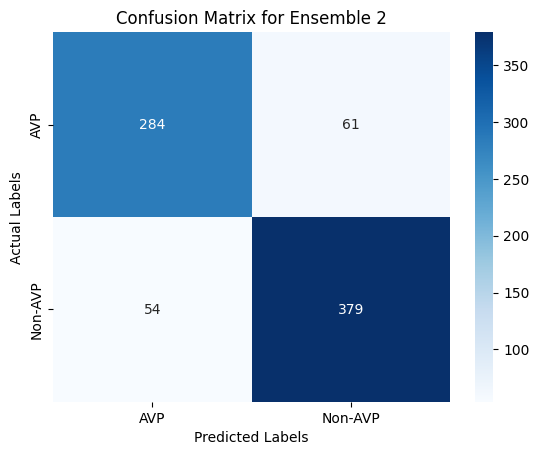

---------------------------------------
Model: Ensemble 3


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: 0.8611825192802056
Confusion Matrix:
[[286  59]
 [ 49 384]]
F1 Score: 0.8767123287671234
Recall: 0.8868360277136259
Precision: 0.8668171557562077
Mean Absolute Error: 0.13881748071979436
Root Mean Squared Error: 0.3725821798204986
ROC AUC Score: 0.8579107674800013


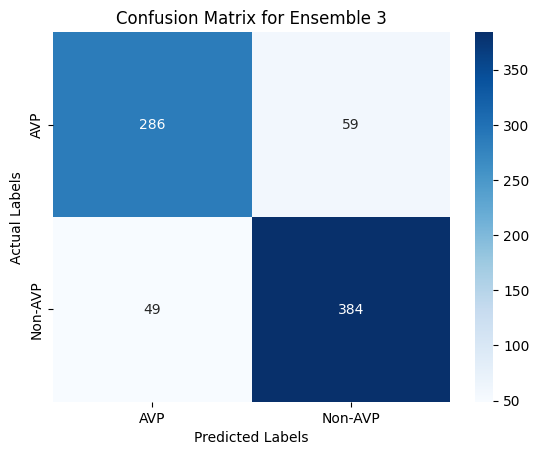

---------------------------------------


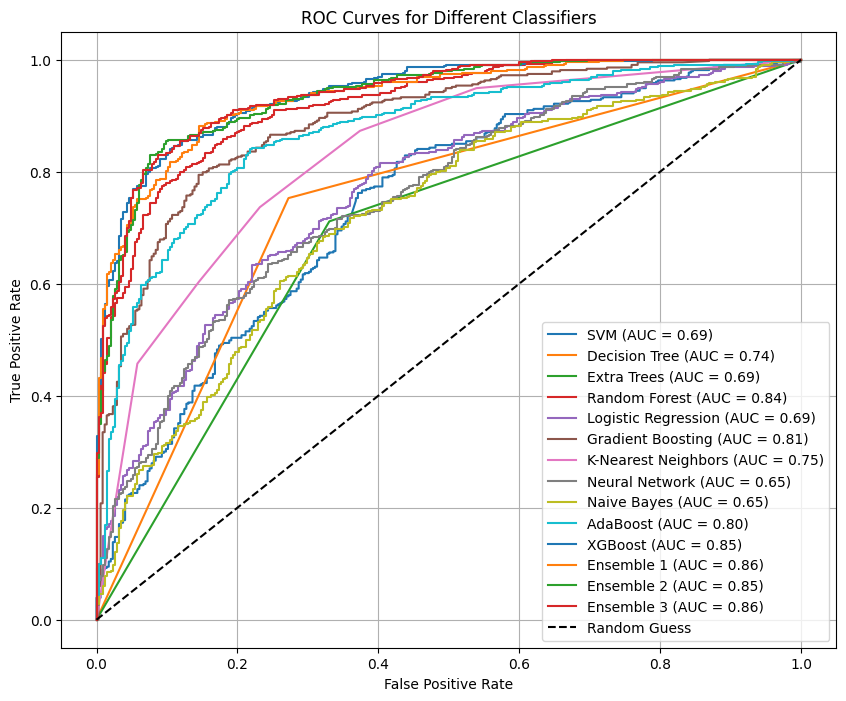

In [7]:

# Initialize lists for ROC data
roc_data = {}

# Train and evaluate each classifier
for name, classifier in classifiers.items():
    print(f"Model: {name}")
    
    classifier.fit(X_train_balanced, y_train_balanced)
    y_pred = classifier.predict(X_test_combined)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:\n{cm}")

    # Calculate F1 score, precision, recall, etc.
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"ROC AUC Score: {roc_auc}")
    
    # Create a heatmap of the confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=["AVP", "Non-AVP"], yticklabels=["AVP", "Non-AVP"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

    # Store ROC curve data
    y_prob = classifier.predict_proba(X_test_combined)[:, 1]  # Probability estimates for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_data[name] = (fpr, tpr, roc_auc)

    print("---------------------------------------")

# Plot all ROC curves in a single plot
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend(loc='lower right')
plt.grid()
plt.show()